In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
train_data, test_data = pd.read_csv('train.csv'), pd.read_csv('test.csv')
print('train shape is: ', train_data.shape, ' and test shape is: ', test_data.shape)

train shape is:  (2056, 13)  and test shape is:  (1372, 12)


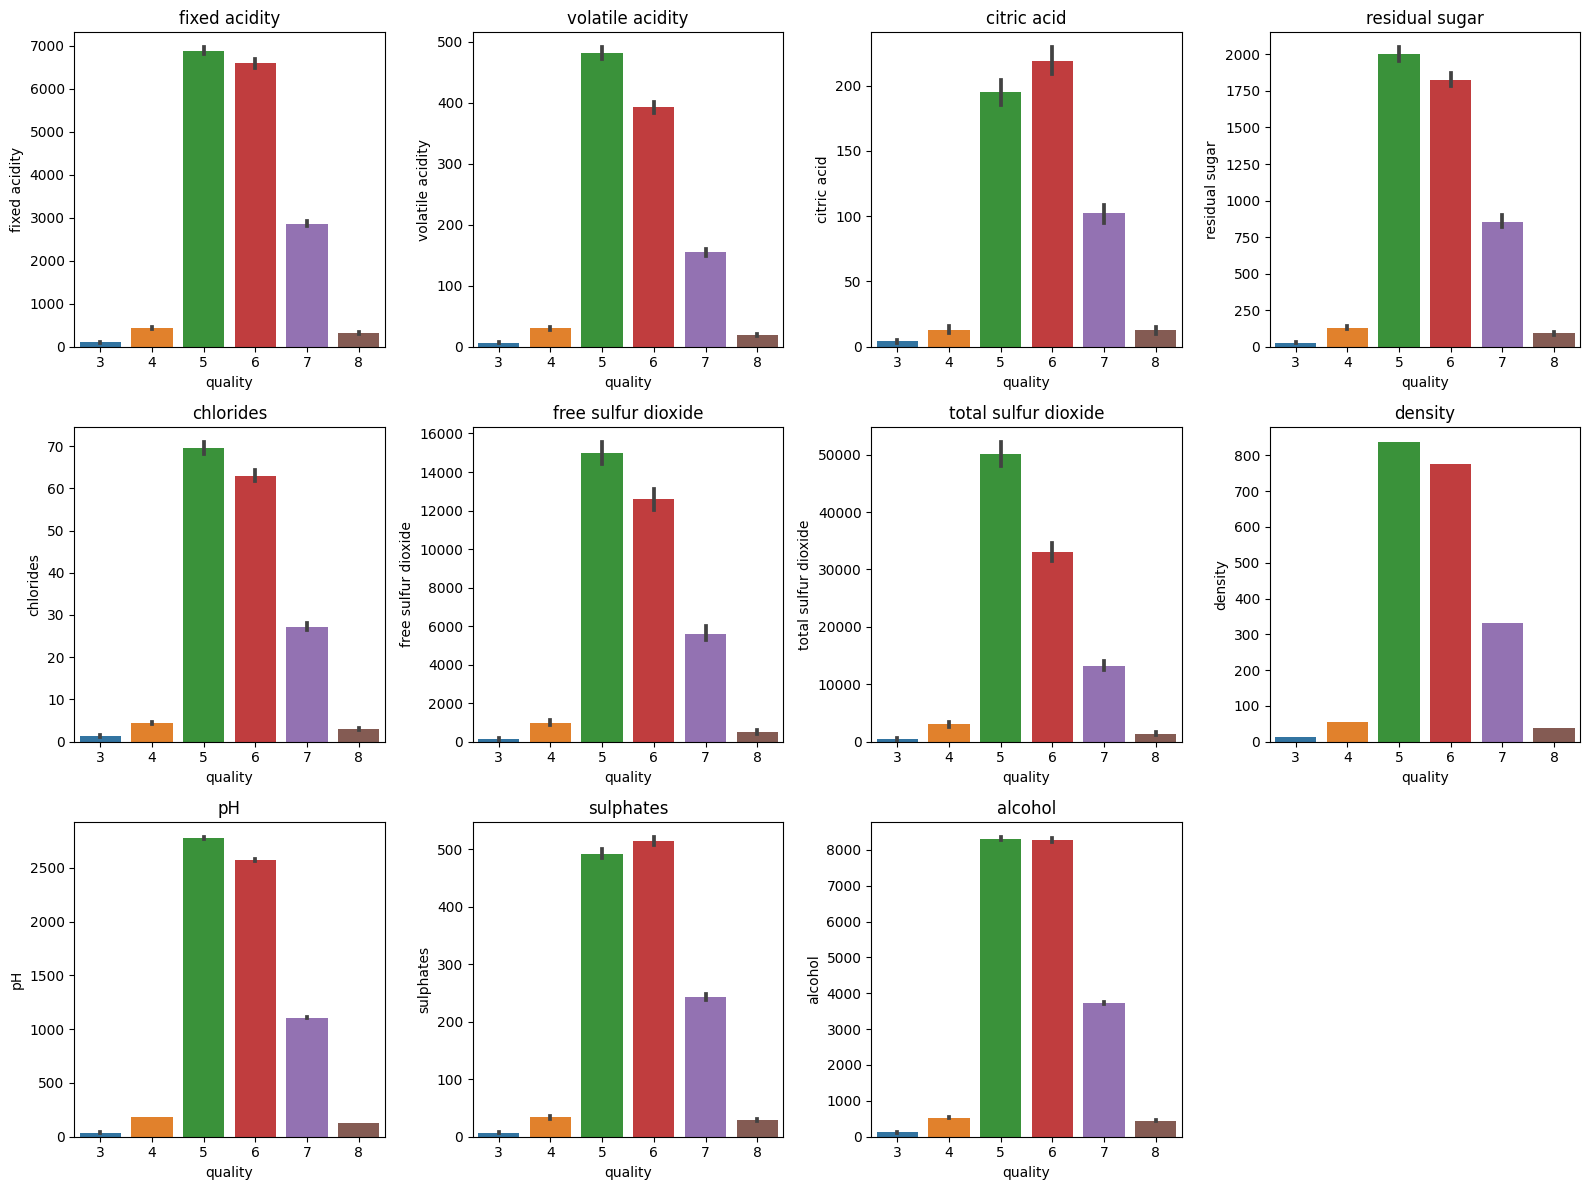

In [27]:
plt.figure(figsize=(16,12))
columns = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
for i in range(len(columns)):
    ax = plt.subplot(3,4,i+1)
    ax.set_title(columns[i])
    sns.barplot(x='quality', y=columns[i], data=train_data, estimator=sum)
plt.tight_layout()

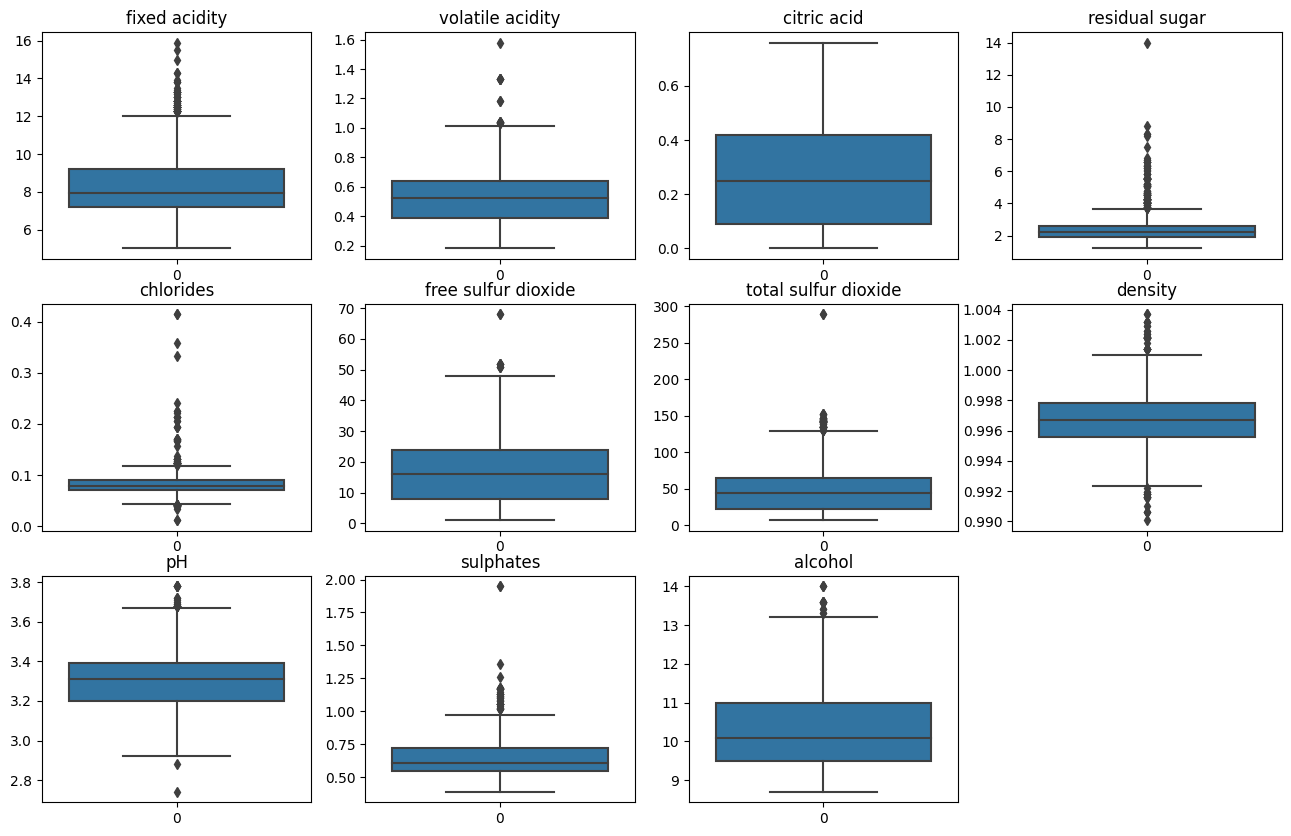

In [28]:
plt.figure(figsize=(16,10))
columns = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
for i in range(len(columns)):
    ax = plt.subplot(3,4,i+1)
    ax.set_title(columns[i])
    sns.boxplot(train_data[columns[i]])

### Cleaning column by column

In [29]:
def plot_variable(column):
    plt.figure(figsize=(10,3))
    ax1 = plt.subplot(1,2,1)
    ax1.set_title('train data')
    sns.histplot(train_data[column])
    ax2 = plt.subplot(1,2,2)
    ax2.set_title('test data')
    sns.histplot(test_data[column])

##### Residual sugar

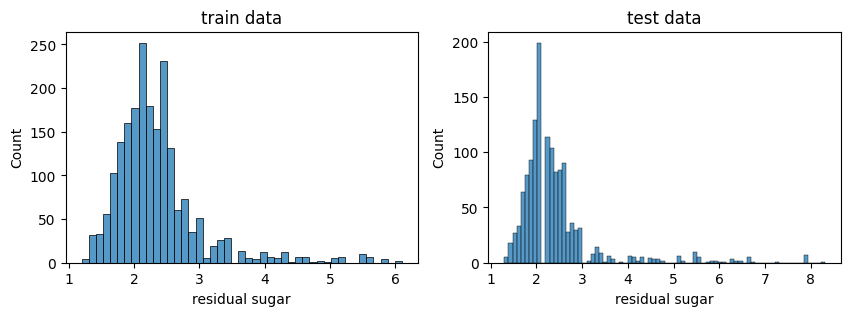

In [51]:
plot_variable('residual sugar')

In [31]:
def fixing_outliers(dataset,column):
    limit = dataset[column].quantile(0.99)
    median = dataset[column].median()
    dataset[column] = np.where(dataset[column]>limit, median, dataset[column])

In [32]:
fixing_outliers(train_data,'residual sugar')

##### Chlorides

Fixing outliers in chlorides decreases score

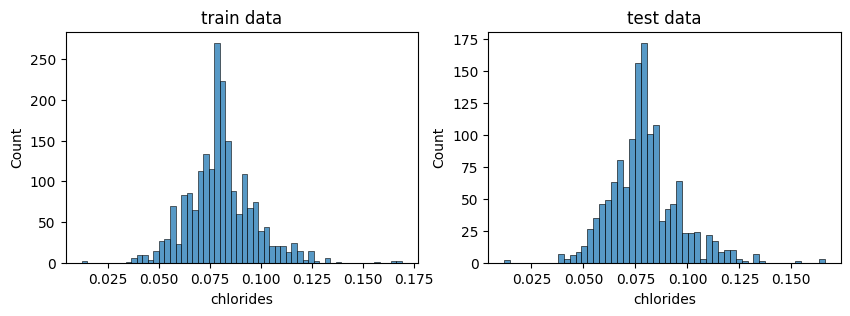

In [54]:
plot_variable('chlorides')

In [35]:
fixing_outliers(train_data, 'chlorides')

In [53]:
fixing_outliers(test_data, 'chlorides')

##### Sulphates

Only fixing outliers in sulphates increases score

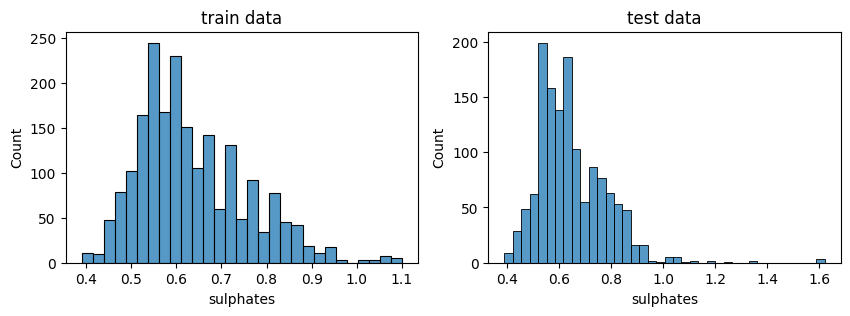

In [52]:
plot_variable('sulphates')

In [37]:
fixing_outliers(train_data,'sulphates')

### Model

In [38]:
y = train_data['quality']
x = train_data.drop(['quality','Id'], axis=1)
x_test = test_data.drop('Id', axis=1)

In [39]:
y = pd.get_dummies(y)

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [41]:
x_test.shape

(1372, 11)

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.1,random_state=42)

In [43]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=11, activation='relu', input_shape=[11]),
    layers.Dense(units=66, activation='relu'),
    layers.Dense(units=6, activation='softmax')
])

In [44]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

In [45]:
history = model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    epochs=200,
    batch_size=200,
    callbacks=early_stopping
)

Epoch 1/200
10/10 [==============================] - 1s 25ms/step - loss: 1.7610 - accuracy: 0.2968 - val_loss: 1.7122 - val_accuracy: 0.4029
Epoch 2/200
10/10 [==============================] - 0s 8ms/step - loss: 1.6768 - accuracy: 0.4124 - val_loss: 1.6230 - val_accuracy: 0.4078
Epoch 3/200
10/10 [==============================] - 0s 13ms/step - loss: 1.5845 - accuracy: 0.4162 - val_loss: 1.5229 - val_accuracy: 0.4175
Epoch 4/200
10/10 [==============================] - 0s 5ms/step - loss: 1.4805 - accuracy: 0.4216 - val_loss: 1.4193 - val_accuracy: 0.4126
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 1.3822 - accuracy: 0.4297 - val_loss: 1.3287 - val_accuracy: 0.4126
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 1.3013 - accuracy: 0.4535 - val_loss: 1.2679 - val_accuracy: 0.4563
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 1.2494 - accuracy: 0.5205 - val_loss: 1.2307 - val_accuracy: 0.4709
Epoch 8/200

In [46]:
result = model.predict(x_test)

43/43 [==============================] - 0s 4ms/step


<AxesSubplot: ylabel='Count'>

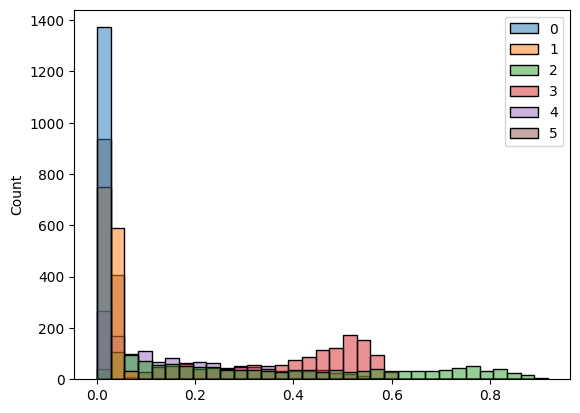

In [47]:
sns.histplot(result)

In [48]:
new_result = []
for row in result:
    new_result.append(list(row).index(max(row))+3)

In [49]:
df = pd.DataFrame({'Id':test_data['Id'].values, 'quality':new_result})
df.to_csv('submission.csv', index=False)